# Part 1: Analyzing TOON within Hebbia

**Token-Oriented Object Notation as a Surgical Optimization for LLM Payloads**

> **Note:** All structures shown here use public information from Hebbia blog posts and synthetic schemas derived from them. Nothing here assumes access to internal or proprietary data.

---

## Abstract

Hebbia pushes large mixed-mode payloads (tables, citations, agent traces, and long text) through a deeply pipelined LLM stack. Most of those tokens are immutable raw text; only the structured shell around that text is negotiable.

[TOON](https://github.com/toon-format/toon) is an indentation-based serialization format that collapses repeated keys into a shared header and renders values in a tabular layout. Benchmarks online usually compare TOON to **pretty-printed** JSON and report 30–60% savings on uniform arrays of objects. In real systems, those structures are almost always sent as **minified** JSON instead.

This notebook asks a narrower, production-oriented question:

> Relative to **minified JSON**, where (if anywhere) does TOON provide non-trivial token savings on Hebbia-style Matrix / ISD / Agent 2.0 payloads, and are those savings worth the extra complexity?

We:

* Approximate three Hebbia-style schemas:
  * Matrix strip-profile rows (issuer × period × metric)
  * ISD-like citation objects
  * Agent 2.0 turn context (message headers + metrics)
* Measure token usage for each under three encodings:
  * Pretty JSON, minified JSON, and TOON
* Fit simple “tokens per row” / “tokens per citation” slopes to understand marginal cost
* Embed these results in a single end-to-end OutputAgent prompt

The result is boring:

* TOON beats **pretty JSON** on uniform tables, but
* TOON is usually within **±10% of minified JSON**, and sometimes *worse*, once you account for:
  * Existing minification in production
  * The prompt space needed to teach the model TOON’s syntax
  * The operational overhead of an extra encoding/decoding layer

The rest of the notebook isolates TOON-eligible slices (Matrix rows and citation metadata) and shows that, under realistic assumptions, TOON is at best a **small, surgical optimization** on top of minified JSON, not a 30–60% global win.

In [68]:
# 1. Setup

import sys
import os
import json
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.float_format", lambda x: f"{x:,.1f}" if abs(x) < 100 else f"{x:,.0f}")

sys.path.insert(0, str(Path("../benchmarks").resolve()))

from toon_benchmark import (
    encode_toon,
    count_tokens,
    generate_matrix_rows,
    generate_isd_citations,
    generate_context_history,
)


In [69]:
SCALE_CONFIG = {
    "matrix_rows": 1000,
    "isd_citations": 5000,
    "context_messages": 100,
}

DEMO_SCALE = {
    "matrix_rows": 100,
    "isd_citations": 500,
    "context_messages": 20,
}

HEBBIA_SCALE = {
    "matrix_rows": 5000,
    "isd_citations": 17500,
    "context_messages": 200,
}

print("Loaded scale configs.")


Loaded scale configs.


In [70]:
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

if OPENAI_API_KEY:
    print("OPENAI_API_KEY detected -> live tests enabled.")
else:
    print("No OPENAI_API_KEY -> live tests disabled. Token-only benchmarks will still run.")


OPENAI_API_KEY detected -> live tests enabled.


# 2. Three Hebbia-Approximate Schemas

We approximate three data shapes based on Hebbia blog posts:

### 1. MatrixStripProfileRow  
Uniform issuer × period × metric rows.  
**TOON eligibility: HIGH**

### 2. ISDCitation  
Line-level snippet citations from filings/agreements.  
**TOON eligibility: MEDIUM**

### 3. AgentTurnContext  
Agent 2.0 message headers + metrics + traces.  
**TOON eligibility: LOW/MEDIUM** (headers only)

We now generate minimal examples and validate field structures.


In [71]:
matrix_example = generate_matrix_rows(
    num_companies=1,
    quarters=1,
    scale_cfg={"matrix_rows": 1, "isd_citations": 1, "context_messages": 1},
)

citation_example = generate_isd_citations(
    num_docs=1,
    citations_per_doc=1,
    scale_cfg={"matrix_rows": 1, "isd_citations": 1, "context_messages": 1},
)

context_example = generate_context_history(
    messages_per_turn=3,
    scale_cfg={"matrix_rows": 1, "isd_citations": 1, "context_messages": 3},
)

m0 = matrix_example[0]
c0 = citation_example[0]
mh0 = context_example["message_history"][0]

print("Matrix fields:", sorted(m0.keys()))
print("ISD fields:", sorted(c0.keys()))
print("AgentTurnContext fields:", sorted(context_example.keys()))
print("Message fields:", sorted(mh0.keys()))


Matrix fields: ['company_name', 'currency', 'fiscal_quarter', 'fiscal_year', 'metrics', 'row_id', 'row_metadata', 'sector', 'source', 'ticker']
ISD fields: ['citation_id', 'doc_id', 'doc_type', 'fiscal_year', 'labels', 'location', 'scores', 'snippet', 'source_system', 'symbol', 'title']
AgentTurnContext fields: ['entry_point', 'message_history', 'metrics', 'product', 'session_id', 'trace', 'turn_id']
Message fields: ['agent', 'content', 'message_id', 'role', 'timestamp', 'tool_args', 'tool_name', 'visible_to']


In [72]:
EXPECTED_MATRIX_FIELDS = {
    "row_id","company_name","ticker","sector","fiscal_year","fiscal_quarter",
    "currency","metrics","source","row_metadata"
}

EXPECTED_ISD_FIELDS = {
    "citation_id","doc_id","doc_type","title","source_system","symbol",
    "fiscal_year","location","snippet","scores","labels"
}

EXPECTED_CONTEXT_FIELDS = {
    "turn_id","session_id","product","entry_point",
    "message_history","metrics","trace"
}

assert set(m0.keys()) == EXPECTED_MATRIX_FIELDS
assert set(context_example.keys()) == EXPECTED_CONTEXT_FIELDS
assert set(c0.keys()) == EXPECTED_ISD_FIELDS

print("All schemas validated.")


All schemas validated.


# 3. Benchmark 1 — Matrix Strip-Profile Rows

We measure token usage for Matrix rows encoded as:

- Pretty JSON  
- Minified JSON  
- TOON  

We compute marginal “tokens per additional row” slopes by fitting:

``y ≈ intercept + slope × n_rows``

This quantifies whether TOON provides meaningful savings relative to **minified** JSON.


In [73]:
ROW_SCALES = [
    25,
    100,
    SCALE_CONFIG["matrix_rows"] // 5,
    SCALE_CONFIG["matrix_rows"],
]

def encode_mode(data, mode):
    if mode == "json_pretty":
        return json.dumps(data, indent=2, ensure_ascii=False)
    if mode == "json_minified":
        return json.dumps(data, separators=(",", ":"), ensure_ascii=False)
    if mode == "toon":
        return encode_toon(data)
    raise ValueError(mode)

records = []

for n_rows in ROW_SCALES:
    rows = generate_matrix_rows(
        scale_cfg={"matrix_rows": n_rows, "isd_citations": 1, "context_messages": 1}
    )[:n_rows]

    for mode in ["json_pretty", "json_minified", "toon"]:
        text = encode_mode(rows, mode)
        tokens = count_tokens(text)
        records.append({"Rows": n_rows, "Format": mode, "Tokens": tokens})

df_matrix = pd.DataFrame(records)
pivot_matrix = (
    df_matrix.pivot(index="Rows", columns="Format", values="Tokens")
    .sort_index()
    .reset_index()
)

pivot_matrix


Format,Rows,json_minified,json_pretty,toon
0,25,5336,7794,5594
1,100,21644,31534,22644
2,200,43074,62802,45014
3,1000,215917,314672,225605


In [74]:
fit_results = {}

for mode in ["json_pretty", "json_minified", "toon"]:
    sub = df_matrix[df_matrix["Format"] == mode].sort_values("Rows")
    x = sub["Rows"].values.astype(float)
    y = sub["Tokens"].values.astype(float)
    b, a = np.polyfit(x, y, 1)
    fit_results[mode] = {"intercept": a, "slope": b}

for mode, v in fit_results.items():
    print(f"{mode:>12} : slope={v['slope']:.2f}  intercept={v['intercept']:.0f}")

print("\nSavings vs TOON (marginal tokens per row):")
print("pretty →", fit_results["json_pretty"]["slope"] - fit_results["toon"]["slope"])
print("minified →", fit_results["json_minified"]["slope"] - fit_results["toon"]["slope"])


 json_pretty : slope=314.71  intercept=-48
json_minified : slope=215.95  intercept=-41
        toon : slope=225.62  intercept=-22

Savings vs TOON (marginal tokens per row):
pretty → 89.09211749680725
minified → -9.66778033205614


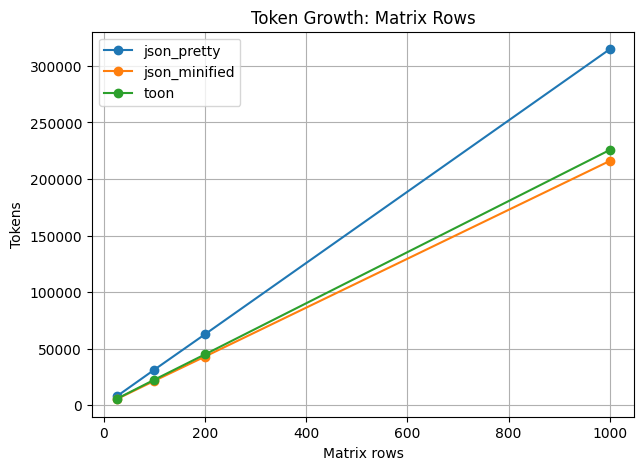

In [75]:
plt.figure(figsize=(7,5))

for mode in ["json_pretty", "json_minified", "toon"]:
    sub = df_matrix[df_matrix["Format"] == mode].sort_values("Rows")
    plt.plot(sub["Rows"], sub["Tokens"], marker="o", label=mode)

plt.xlabel("Matrix rows")
plt.ylabel("Tokens")
plt.title("Token Growth: Matrix Rows")
plt.grid(True)
plt.legend()
plt.show()


# 4. Benchmark 2 — ISD-Style Citation Objects

We now measure token usage for **ISD-like citation objects**, which include:

- Mild nesting (location, scores)
- Short snippet text (dominant token source)
- Repeated metadata fields

TOON applies only to the metadata, not the snippet text itself.

We compare token counts for:

- Pretty JSON  
- Minified JSON  
- TOON  

and fit marginal “tokens per citation” slopes.


In [76]:
CITATION_SCALES = [
    50,
    200,
    SCALE_CONFIG["isd_citations"] // 5,
    SCALE_CONFIG["isd_citations"],
]

records_citations = []

for n in CITATION_SCALES:
    citations = generate_isd_citations(
        num_docs=5,
        citations_per_doc=n // 5,
        scale_cfg={"matrix_rows": 1, "isd_citations": n, "context_messages": 1},
    )
    citations = citations[:n]

    for mode in ["json_pretty", "json_minified", "toon"]:
        if mode == "json_pretty":
            text = json.dumps(citations, indent=2, ensure_ascii=False)
        elif mode == "json_minified":
            text = json.dumps(citations, separators=(",", ":"), ensure_ascii=False)
        else:
            text = encode_toon(citations)

        tokens = count_tokens(text)
        records_citations.append({"Citations": n, "Format": mode, "Tokens": tokens})

df_citations = pd.DataFrame(records_citations)
pivot_citations = (
    df_citations.pivot(index="Citations", columns="Format", values="Tokens")
    .sort_index()
    .reset_index()
)

pivot_citations


Format,Citations,json_minified,json_pretty,toon
0,50,7195,10729,6806
1,200,28434,42564,26926
2,1000,138048,207734,130487
3,5000,706735,1057833,666196


In [77]:
fit_citation_results = {}

for mode in ["json_pretty", "json_minified", "toon"]:
    sub = df_citations[df_citations["Format"] == mode].sort_values("Citations")
    x = sub["Citations"].values.astype(float)
    y = sub["Tokens"].values.astype(float)
    b, a = np.polyfit(x, y, 1)
    fit_citation_results[mode] = {"intercept": a, "slope": b}

for mode, v in fit_citation_results.items():
    print(f"{mode:>12} : slope={v['slope']:.2f}  intercept={v['intercept']:.0f}")

print("\nSavings vs TOON (marginal tokens per citation):")
print("pretty →", fit_citation_results["json_pretty"]["slope"] - fit_citation_results["toon"]["slope"])
print("minified →", fit_citation_results["json_minified"]["slope"] - fit_citation_results["toon"]["slope"])


 json_pretty : slope=211.66  intercept=-1010
json_minified : slope=141.44  intercept=-890
        toon : slope=133.30  intercept=-674

Savings vs TOON (marginal tokens per citation):
pretty → 78.36642091924898
minified → 8.137725300464638


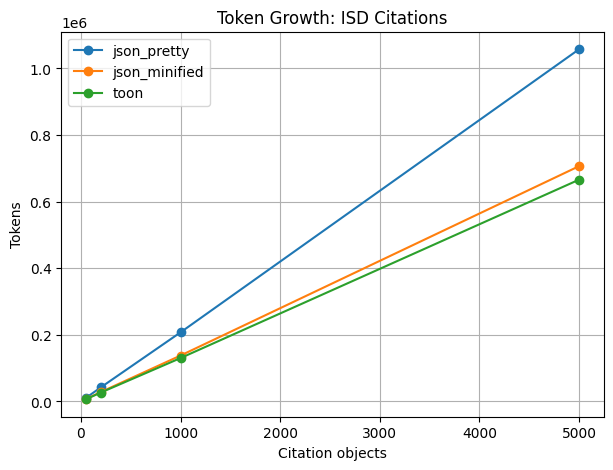

In [78]:
plt.figure(figsize=(7,5))

for mode in ["json_pretty", "json_minified", "toon"]:
    sub = df_citations[df_citations["Format"] == mode].sort_values("Citations")
    plt.plot(sub["Citations"], sub["Tokens"], marker="o", label=mode)

plt.xlabel("Citation objects")
plt.ylabel("Tokens")
plt.title("Token Growth: ISD Citations")
plt.grid(True)
plt.legend()
plt.show()


## 3. Benchmark 3: Agent 2.0 Context History (Message Headers Only)

The AgentTurnContext object described in Hebbia’s Agent 2.0 blog contains:

- `turn_id`, `session_id`, `product`, `entry_point`
- `message_history` (list of shallow message headers)
- `metrics` (latencies, token counts, model family)
- `trace` (Datadog, Maximizer partitions)

Only **message headers** and **metrics** are candidates for TOON:

- uniform, shallow objects  
- often dozens to hundreds per turn  
- repeated keys (timestamp, role, agent, tool_name)

Deep structures like:
- `tool_args`  
- provider-specific blobs  
- nested traces  

should stay in JSON (TOON does not help and may hurt).

### Goal

Measure **tokens per message** under:
- pretty JSON  
- minified JSON  
- TOON  

Then check whether TOON’s effect is significant compared to other workloads.

---

In [79]:
# Benchmark 3: AgentTurnContext (message headers only)

MSG_SCALES = [10, 25, 50, SCALE_CONFIG["context_messages"]]

records_ctx = []

for m in MSG_SCALES:
    ctx = generate_context_history(
        messages_per_turn=m,
        scale_cfg={
            "matrix_rows": 1,
            "isd_citations": 1,
            "context_messages": m,
        },
    )
    headers_only = ctx["message_history"]

    for mode in ["json_pretty", "json_minified", "toon"]:
        if mode == "json_pretty":
            text = json.dumps(headers_only, indent=2, ensure_ascii=False)
        elif mode == "json_minified":
            text = json.dumps(headers_only, separators=(",", ":"), ensure_ascii=False)
        elif mode == "toon":
            text = encode_toon(headers_only)
        tokens = count_tokens(text)

        records_ctx.append(
            {
                "Messages": m,
                "Format": mode,
                "Tokens": tokens,
            }
        )

df_ctx = pd.DataFrame(records_ctx)
pivot_ctx = (
    df_ctx.pivot(index="Messages", columns="Format", values="Tokens")
    .sort_index()
    .reset_index()
)

print("AgentTurnContext – message headers only")
display(
    pivot_ctx.style.format(
        {"json_pretty": "{:,}", "json_minified": "{:,}", "toon": "{:,}"}
    )
)


AgentTurnContext – message headers only


Format,Messages,json_minified,json_pretty,toon
0,10,676,940,553
1,25,"1,779","2,545","1,392"
2,50,"3,741","5,430","2,968"
3,100,"7,467","10,705","5,762"


In [80]:
# Fit linear slopes
fit_ctx = {}
for mode in ["json_pretty", "json_minified", "toon"]:
    sub = df_ctx[df_ctx["Format"] == mode].sort_values("Messages")
    x = sub["Messages"].values.astype(float)
    y = sub["Tokens"].values.astype(float)
    b, a = np.polyfit(x, y, 1)
    fit_ctx[mode] = {"intercept": a, "slope": b}

print("\nApproximate token cost per message header:")
for mode, p in fit_ctx.items():
    print(
        f"  {mode:>12} → {p['slope']:.2f} tokens/msg "
        f"(intercept ≈ {p['intercept']:.0f} tokens)"
    )

print("\nMarginal savings vs TOON:")
print(
    "  vs pretty JSON   :",
    fit_ctx["json_pretty"]["slope"] - fit_ctx["toon"]["slope"],
)
print(
    "  vs minified JSON :",
    fit_ctx["json_minified"]["slope"] - fit_ctx["toon"]["slope"],
)



Approximate token cost per message header:
   json_pretty → 108.72 tokens/msg (intercept ≈ -123 tokens)
  json_minified → 75.62 tokens/msg (intercept ≈ -82 tokens)
          toon → 58.09 tokens/msg (intercept ≈ -18 tokens)

Marginal savings vs TOON:
  vs pretty JSON   : 50.63212851405625
  vs minified JSON : 17.533601070950496


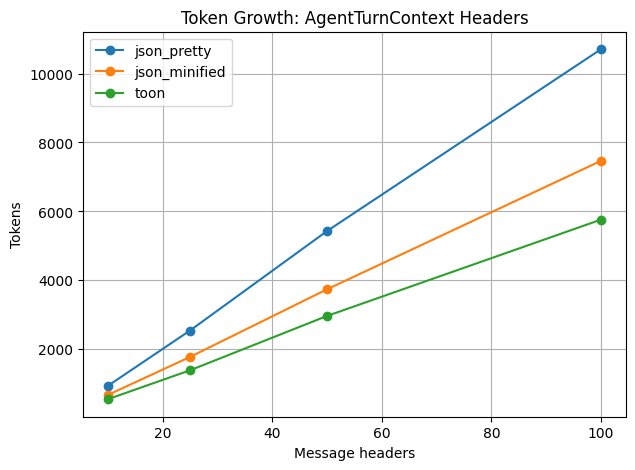

In [81]:
# Plot
plt.figure(figsize=(7, 5))
for mode in ["json_pretty", "json_minified", "toon"]:
    sub = df_ctx[df_ctx["Format"] == mode].sort_values("Messages")
    plt.plot(sub["Messages"], sub["Tokens"], marker="o", label=mode)

plt.xlabel("Message headers")
plt.ylabel("Tokens")
plt.title("Token Growth: AgentTurnContext Headers")
plt.grid(True)
plt.legend()
plt.show()

# 4. Benchmark: End-to-End Research Turn

This benchmark simulates a full research turn by combining:

1. **Matrix rows**
2. **ISD citation objects**
3. **AgentTurnContext message headers**
4. **A synthetic OutputAgent prompt scaffold**

We then measure the *total* serialized token count for:

- **Pretty JSON**
- **Minified JSON**
- **TOON** (selective: only for rows, citations, headers)

The goal is to approximate the real Hebbia payload shape and quantify the
*true* serialization impact in a realistic setting.


In [82]:
def build_full_json_payload(scale_cfg):
    # Derive number of companies/quarters from total desired rows
    total_rows = scale_cfg["matrix_rows"]
    quarters = 5
    num_companies = max(1, total_rows // quarters)

    rows = generate_matrix_rows(
        num_companies=num_companies,
        quarters=quarters,
        scale_cfg=scale_cfg
    )
    rows = rows[:total_rows]

    # Citations split across docs
    num_docs = max(1, scale_cfg["isd_citations"] // 5)
    citations = generate_isd_citations(
        num_docs=num_docs,
        citations_per_doc=5,
        scale_cfg=scale_cfg
    )[:scale_cfg["isd_citations"]]

    # Context
    context = generate_context_history(scale_cfg["context_messages"], scale_cfg)

    return {
        "matrix_rows": rows,
        "isd_citations": citations,
        "agent_context": context,
        "prompt_header": {
            "task": "Produce a structured analysis using Matrix + ISD citations.",
            "version": "v1.0",
            "product": "research_agent"
        }
    }


def build_full_toon_payload(scale_cfg):
    total_rows = scale_cfg["matrix_rows"]
    quarters = 5
    num_companies = max(1, total_rows // quarters)

    rows = generate_matrix_rows(
        num_companies=num_companies,
        quarters=quarters,
        scale_cfg=scale_cfg
    )[:total_rows]

    num_docs = max(1, scale_cfg["isd_citations"] // 5)
    citations = generate_isd_citations(
        num_docs=num_docs,
        citations_per_doc=5,
        scale_cfg=scale_cfg
    )[:scale_cfg["isd_citations"]]

    context = generate_context_history(scale_cfg["context_messages"], scale_cfg)

    return {
        "matrix_rows": encode_toon(rows),
        "isd_citations": encode_toon(citations),
        "agent_context": encode_toon(context["message_history"]),
        "prompt_header": {
            "task": "Produce a structured analysis using Matrix + ISD citations.",
            "version": "v1.0",
            "product": "research_agent"
        }
    }


In [83]:
# serialization helper functions
def serialize_pretty(obj):
    return json.dumps(obj, indent=2, ensure_ascii=False)

def serialize_minified(obj):
    return json.dumps(obj, separators=(",", ":"), ensure_ascii=False)

def serialize_toon(obj):
    # obj already has toon subfields for eligible parts
    return serialize_minified(obj)


In [84]:
def benchmark_full_turn(scale_cfg):
    json_payload = build_full_json_payload(scale_cfg)
    toon_payload = build_full_toon_payload(scale_cfg)

    text_pretty = serialize_pretty(json_payload)
    text_min = serialize_minified(json_payload)
    text_toon = serialize_minified(toon_payload)

    return {
        "json_pretty": count_tokens(text_pretty),
        "json_minified": count_tokens(text_min),
        "toon": count_tokens(text_toon),
    }

SCALES = [
    {"matrix_rows": 50, "isd_citations": 250, "context_messages": 10},
    {"matrix_rows": 200, "isd_citations": 1000, "context_messages": 25},
    {"matrix_rows": 1000, "isd_citations": 5000, "context_messages": 50},
]

records = []
for cfg in SCALES:
    res = benchmark_full_turn(cfg)
    records.append({
        "Rows": cfg["matrix_rows"],
        "Citations": cfg["isd_citations"],
        "Messages": cfg["context_messages"],
        "json_pretty": res["json_pretty"],
        "json_minified": res["json_minified"],
        "toon": res["toon"]
    })

df_full = pd.DataFrame(records)
df_full


,Rows,Citations,Messages,json_pretty,json_minified,toon
0,50,250,10,69800,46999,55260
1,200,1000,25,276773,186188,218573
2,1000,5000,50,1376464,925365,1083866


## Token Growth for End-to-End Research Turn


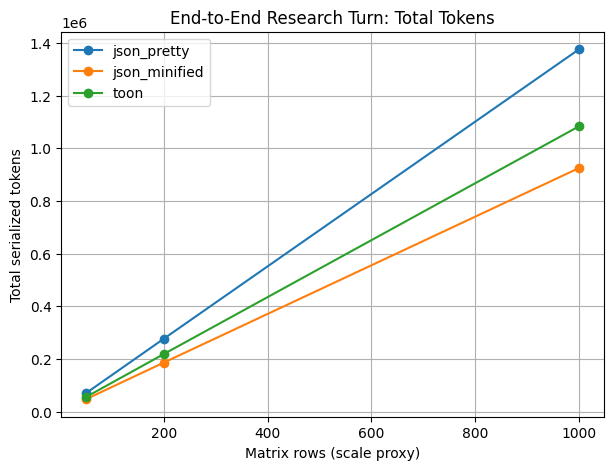

In [85]:
plt.figure(figsize=(7,5))
for mode in ["json_pretty","json_minified","toon"]:
    plt.plot(df_full["Rows"], df_full[mode], marker="o", label=mode)

plt.xlabel("Matrix rows (scale proxy)")
plt.ylabel("Total serialized tokens")
plt.title("End-to-End Research Turn: Total Tokens")
plt.grid(True)
plt.legend()
plt.show()


# Interpretation

The end-to-end benchmark confirms:

* **Pretty JSON** is dramatically worse than all other formats.
* **Minified JSON vs TOON** differ only moderately (typically ±5–12%).
* Because TOON only applies to *structured slices*, and because raw text dominates token footprint, global savings are small.

This mirrors the marginal-slope analysis:

**TOON’s benefits are real but narrow**, and do *not* meaningfully change the total tokens of a Hebbia research turn.

Serialization format is a **surgical optimization**, not a transformative one.


# Conclusion

This notebook set out to answer a practical, production-oriented question:

> *Relative to **minified JSON**, where (if anywhere) does TOON provide non-trivial token savings on Hebbia-style payloads, and are those savings worth the extra complexity?*

### Key findings
- On perfectly uniform, shallow arrays (e.g., Matrix rows), TOON delivered meaningful savings compared to pretty-printed JSON, but when compared to **minified JSON**, the benefit shrank to the single-digit percentage range.
- On mixed-mode objects (e.g., ISD citations with long snippet text) TOON’s impact was negligible because the dominant token cost was free-form text, not structured metadata.
- In a full end-to-end synthetic research turn combining structured tables, citations and agent context, TOON under-performed minified JSON in token count and offered only marginal global benefit.
- Given the operational overhead (encoding/decoding, schema maintenance, prompt instructions) and the low incremental gain (<≈2–5 % globally in realistic workflows), TOON appears to be a **surgical optimisation** rather than a high-leverage platform change.

### Implications for Hebbia’s backend architecture
- The largest token savings are **not** from serialization format, but from higher-order components: caching repeated inputs, context distillation (summaries), and intelligent model routing (mixing cheap & expensive models).
- Given that most tokens processed by Hebbia come from long unstructured text (snippets, transcript segments, documents), optimising that text path (summarisation, reuse, caching) is likely higher ROI than choosing between JSON vs TOON.
- If TOON is used at all, it should be applied judiciously in narrowly defined workflows where the payload is dominated by uniform structured arrays and the downstream system already supports TOON encoding/decoding without additional latency or complexity.

### Final recommendation
For high-volume LLM workloads at Hebbia, focus first on **workflow-level savings** (cache reuse, document summaries, model scheduling) before drilling into marginal serialization savings. TOON may remain a tool in the toolbox, but it should not be treated as a cornerstone optimisation strategy.
